# E.Coli Timeseries

This notebooks loads, reshapes and prepare the necessary data to draw time series about E.Coli concentration in the Charles River. It uses the data extracted by [bhushan](https://github.com/codeforboston/safe-water/blob/master/projects/crwa/notebooks/bhushan-eda.ipynb) and saved as [data_for_prototype.csv](https://github.com/codeforboston/safe-water/blob/master/projects/crwa/data/sampling_datasets/data_for_prototype.csv) there.  

## Observations, questions and decisions

* Grouping and aggregating by site will not be easy, as there are 168 of them... Eventually we could select a few of them (e.g. "Watertown Dam Footbridge" or "Rt. 109 Bridge"), or we should not aggregate by site at all. Or use _River Mile_, but still 35 of them.
* Two types of units exist for E Coli, cfu/100ml and MPN/100ml, but in our case we can consider them as equivalent (I think).  
* Escherichia coli was sampled very regularly, although for some months no samples were collected.
* The data starts in 2002 (1 date in 2000), why not 1995?
* The distribution of E.Coli concentration by year or month has a long tail to the right, with some very large outilers.
* When pooling all samples (i.e. all sampling sites) together, it is quite common for the median E.Coli concentration to be above the swimming limit. It is a lot rarer for the boating limit. ==> see plot.
* Even when you focus on a single _site_, you need to aggreagate by month because sometimes several samples are taken in the same month (e.g. 2 samples at same date)
* It happens quite regularly that the E.Coli concentration is above the boating or even swimming at the Watertown Dam Bridge. ==> see plot.

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 200)
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
samples = pd.read_csv("../data/sampling_datasets/data_for_prototype.csv")
print(samples.shape)
samples.head()

(46135, 15)


,Date_Collected,Time_Collected,Component_Name,Site_ID,Site_Name,Town,River_Mile_Headwaters,Latitude_DD,Longitude_DD,Actual_Result,Result_Type,Unit_Abbreviation,Reporting_Result,Result_Type-2,Unit_Abbreviation-2
0,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",521S,Ames St. Bridge,Dedham,52.1 MI,42.2524,-71.1763,27.6,Actual,deg C,27.6,Actual,deg C
1,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",534S,Rt. 109 Bridge,Boston/Dedham,53.4 MI,42.2708,-71.1732,23,Actual,deg C,23.0,Actual,deg C
2,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",567S,Nahanton Park,Needham/Newton,56.7 MI,42.2971,-71.2078,22.3,Actual,deg C,22.3,Actual,deg C
3,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",621S,Leo J. Martin Golf Course / Park Rd.,Newton/Weston,62.1 MI,42.3306,-71.2680,22.6,Actual,deg C,22.6,Actual,deg C
4,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",648S,"Auburndale Park, Lakes Region",Waltham,64.8 MI,42.3615,-71.2501,22.8,Actual,deg C,22.8,Actual,deg C


In [3]:
# too many sites to draw a dataviz by site...
samples.Site_Name.value_counts()

Watertown Dam Footbridge                                                                                                  1554
Rt. 109 Bridge                                                                                                            1540
Central Street Bridge                                                                                                     1524
West St. / Dover Rd.                                                                                                      1518
Moody St. Bridge                                                                                                          1516
Western Ave. Bridge                                                                                                       1474
New Charles River Dam                                                                                                     1459
Massachusetts Ave. (Harvard) Bridge                                                                            

In [4]:
# E Coli is one of the Component_Name:
samples.Component_Name.value_counts()

Temperature, water                               9540
Escherichia coli                                 8321
Depth                                            7143
Fecal coliform                                   4437
Phosphorus                                       1884
Enterococcus                                     1297
Total suspended solids                           1166
Specific conductance                             1152
Inorganic nitrogen (nitrate and nitrite)         1143
Dissolved oxygen (DO)                            1036
Orthophosphate                                   1030
Nitrogen                                         1013
Ammonia                                          1004
Chlorophyll a                                     998
pH                                                987
Pheophytin a                                      976
Salinity                                          775
Dissolved oxygen saturation                       672
Algae, blue-green (phylum cy

  
Note by Lisa on which result to use:

_**The 'Actual Results' is what we get from the lab. The 'Reporting Results' is what should be used in analyses.** Most of the time the Actual Result = the Reporting Result. Sometimes, the Actual Result will hit a lab detection limit and be reported as (for example) <10 or >2400 - at that time, we have protocols to remove those symbols. For <, the value is halved (ex. Actual Result <10 becomes Reporting Result 5) and for >, the symbol is removed. This is also reflected in the 'Reporting Result Type ID' column - that value will be 'Calculated' when any of these rules are applied._

In [6]:
# select the necessary variables and filter for E.Coli:
e_coli = samples[['Date_Collected', 'Component_Name', 'Reporting_Result', 'Unit_Abbreviation']]
e_coli = e_coli[e_coli['Component_Name'] == "Escherichia coli"] # filter to keep only E.Coli
# e_coli.Date_Collected = pd.to_datetime(e_coli.Date_Collected) # , utc=True).dt.date
e_coli.Date_Collected = pd.to_datetime(e_coli.Date_Collected, utc=True).dt.date
e_coli.Date_Collected = pd.to_datetime(e_coli.Date_Collected) # not sure why I have to redo this so that it remains in datetime format?
print(e_coli.shape)
e_coli.head()

(8321, 4)


,Date_Collected,Component_Name,Reporting_Result,Unit_Abbreviation
6798,2000-08-25,Escherichia coli,50.0,cfu/100ml
9718,2002-06-18,Escherichia coli,240.0,cfu/100ml
9720,2002-06-18,Escherichia coli,130.0,cfu/100ml
9722,2002-06-18,Escherichia coli,190.0,cfu/100ml
9747,2002-06-18,Escherichia coli,195.0,cfu/100ml


In [7]:
# if the same unit is always used, we can delete the column:
e_coli.Unit_Abbreviation.value_counts()
# ==> it's not!

MPN/100ml    5613
cfu/100ml    2708
Name: Unit_Abbreviation, dtype: int64

According to [this website](http://www.transformcompostsystems.com/blog/2017/06/24/managing-potential-pathogenic-bacteria-mpn-or-cfu-are-they-the-same/):  

_CFU refers to “colony forming units”, whereas MPN refers to “most probable number”. The difference is that CFU/100ml is the actual count from the surface of a plate, and MPN/100ml is a statistical probability of the number of organisms (American Public Health 2012)._

There are not always equivalent, but we will assume that they are for this analysis (on [CRWA's website](https://www.crwa.org/water-quality-data.html), the text says _cfu_, but the table says _MPN_...)

In [8]:
print("we have so many rows (dates): ", e_coli.Date_Collected.shape)
print("and so many unique dates: ", e_coli.Date_Collected.nunique())

we have so many rows (dates):  (8321,)
and so many unique dates:  525


In [9]:
# we don't have any NAs:
e_coli.isnull().sum()

Date_Collected       0
Component_Name       0
Reporting_Result     0
Unit_Abbreviation    0
dtype: int64

Let's try to plot the results by date to see how it looks like.


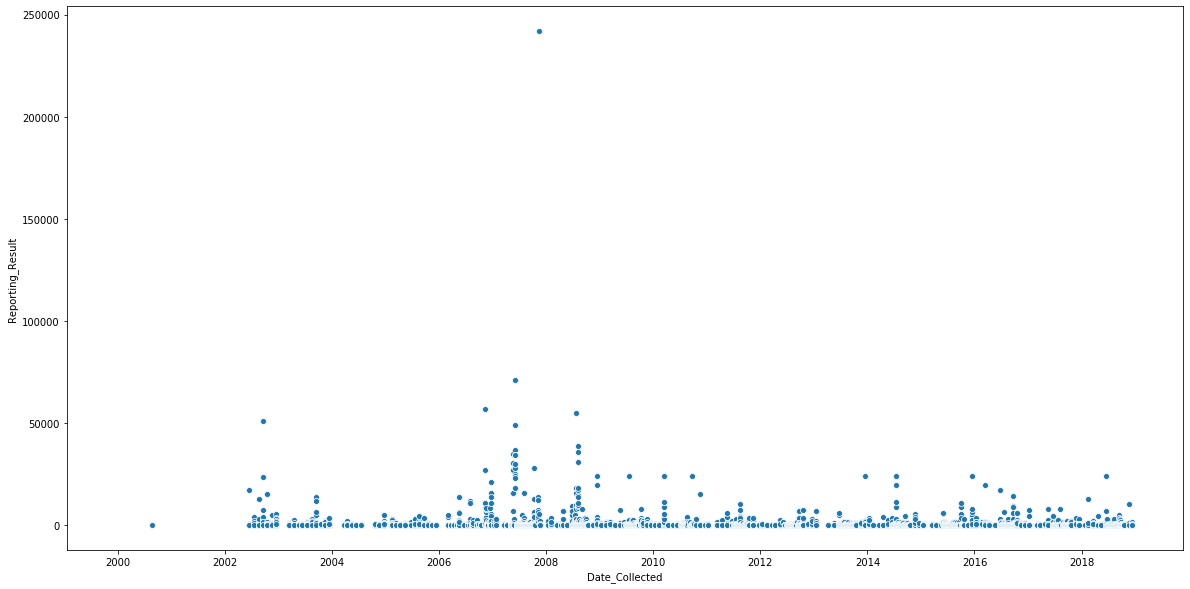

In [10]:
plt.figure(figsize=(20,10))
# sns.lineplot(x='Date_Collected', y='Reporting_Result', data = e_coli)
sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = e_coli)
plt.show()

Wow, we have some large outliers! According to [CRWA's website](https://www.crwa.org/water-quality-data.html), the state water quality standards for swimming are < 126 cfu/100 mL and boating < 630 cfu/100 mL.  

In [11]:
# let's remove the single date before 2002:
e_coli = e_coli[e_coli['Date_Collected'] > "2002-01-01"]

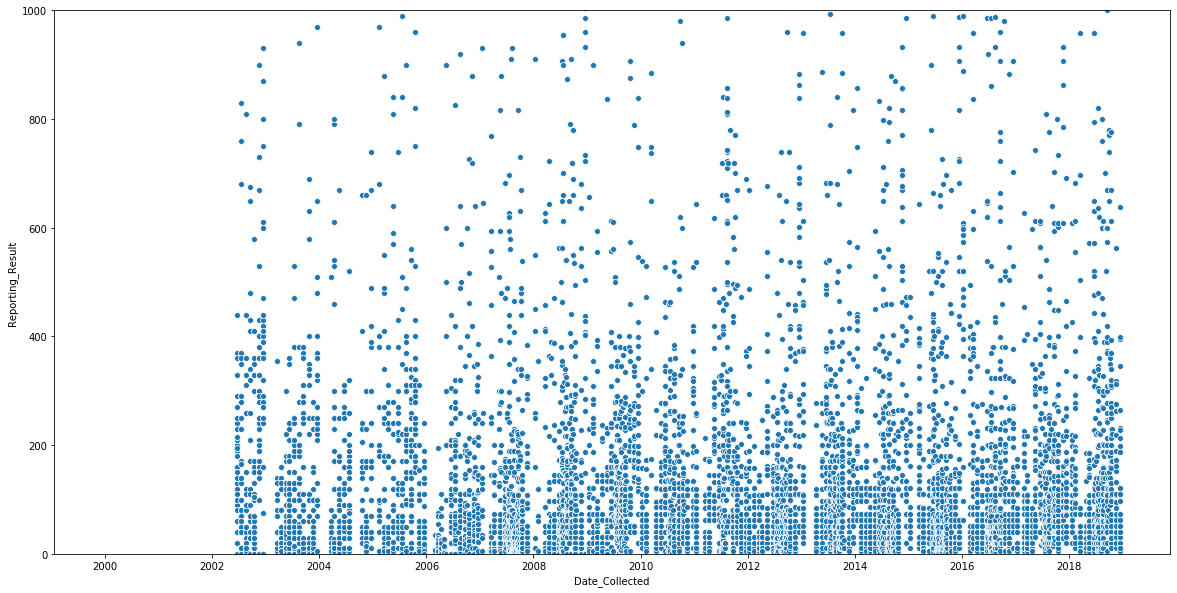

In [12]:
# let's plot again, by limiting the y axis, just to see:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = e_coli)
ax.set(ylim=(0, 1000))
plt.show()

Let's start very simple and aggregate the data by taking the median of E.Coli concentration by year:

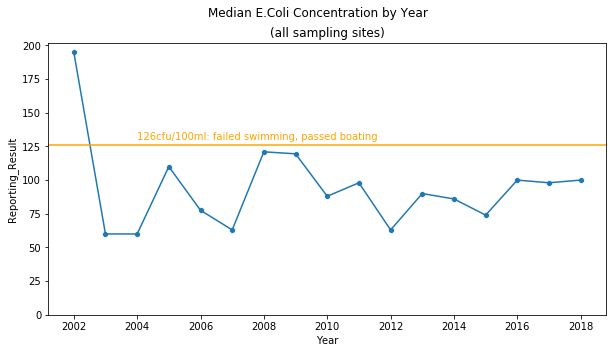

In [13]:
# Median E coli concentration by year. Not super interesting

e_coli['Year'] = e_coli.Date_Collected.dt.year # add year
e_coli_year = e_coli.groupby('Year', as_index=False)['Reporting_Result'].median()

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='Year', y='Reporting_Result', data = e_coli_year)
ax = sns.lineplot(x='Year', y='Reporting_Result', data = e_coli_year)
ax.set(ylim=(0, None)) # make sure to start at 0
ax.axhline(126, color="orange") # failed swimming, passed boating
ax.text(2004,130, "126cfu/100ml: failed swimming, passed boating", color="orange")
plt.suptitle("Median E.Coli Concentration by Year")
plt.title("(all sampling sites)")
plt.show()

Median by month:

In [14]:
# instead of creating a new column, this time we try it differently, by changing the index to datetime:
print('index of df:', e_coli.index)
e_coli.set_index(e_coli["Date_Collected"], inplace=True)
print('index of df:', e_coli.index)

index of df: Int64Index([ 9718,  9720,  9722,  9747,  9748,  9749,  9750,  9751,  9752,
             9753,
            ...
            46086, 46091, 46092, 46093, 46097, 46103, 46104, 46117, 46118,
            46125],
           dtype='int64', length=8320)
index of df: DatetimeIndex(['2002-06-18', '2002-06-18', '2002-06-18', '2002-06-18',
               '2002-06-18', '2002-06-18', '2002-06-18', '2002-06-18',
               '2002-06-18', '2002-06-18',
               ...
               '2018-12-11', '2018-12-11', '2018-12-11', '2018-12-11',
               '2018-12-11', '2018-12-11', '2018-12-11', '2018-12-11',
               '2018-12-11', '2018-12-11'],
              dtype='datetime64[ns]', name='Date_Collected', length=8320, freq=None)


In [15]:
 # we groub by month and take the median:
e_coli_month = e_coli.groupby(pd.Grouper(freq='M'))['Reporting_Result'].median().reset_index()

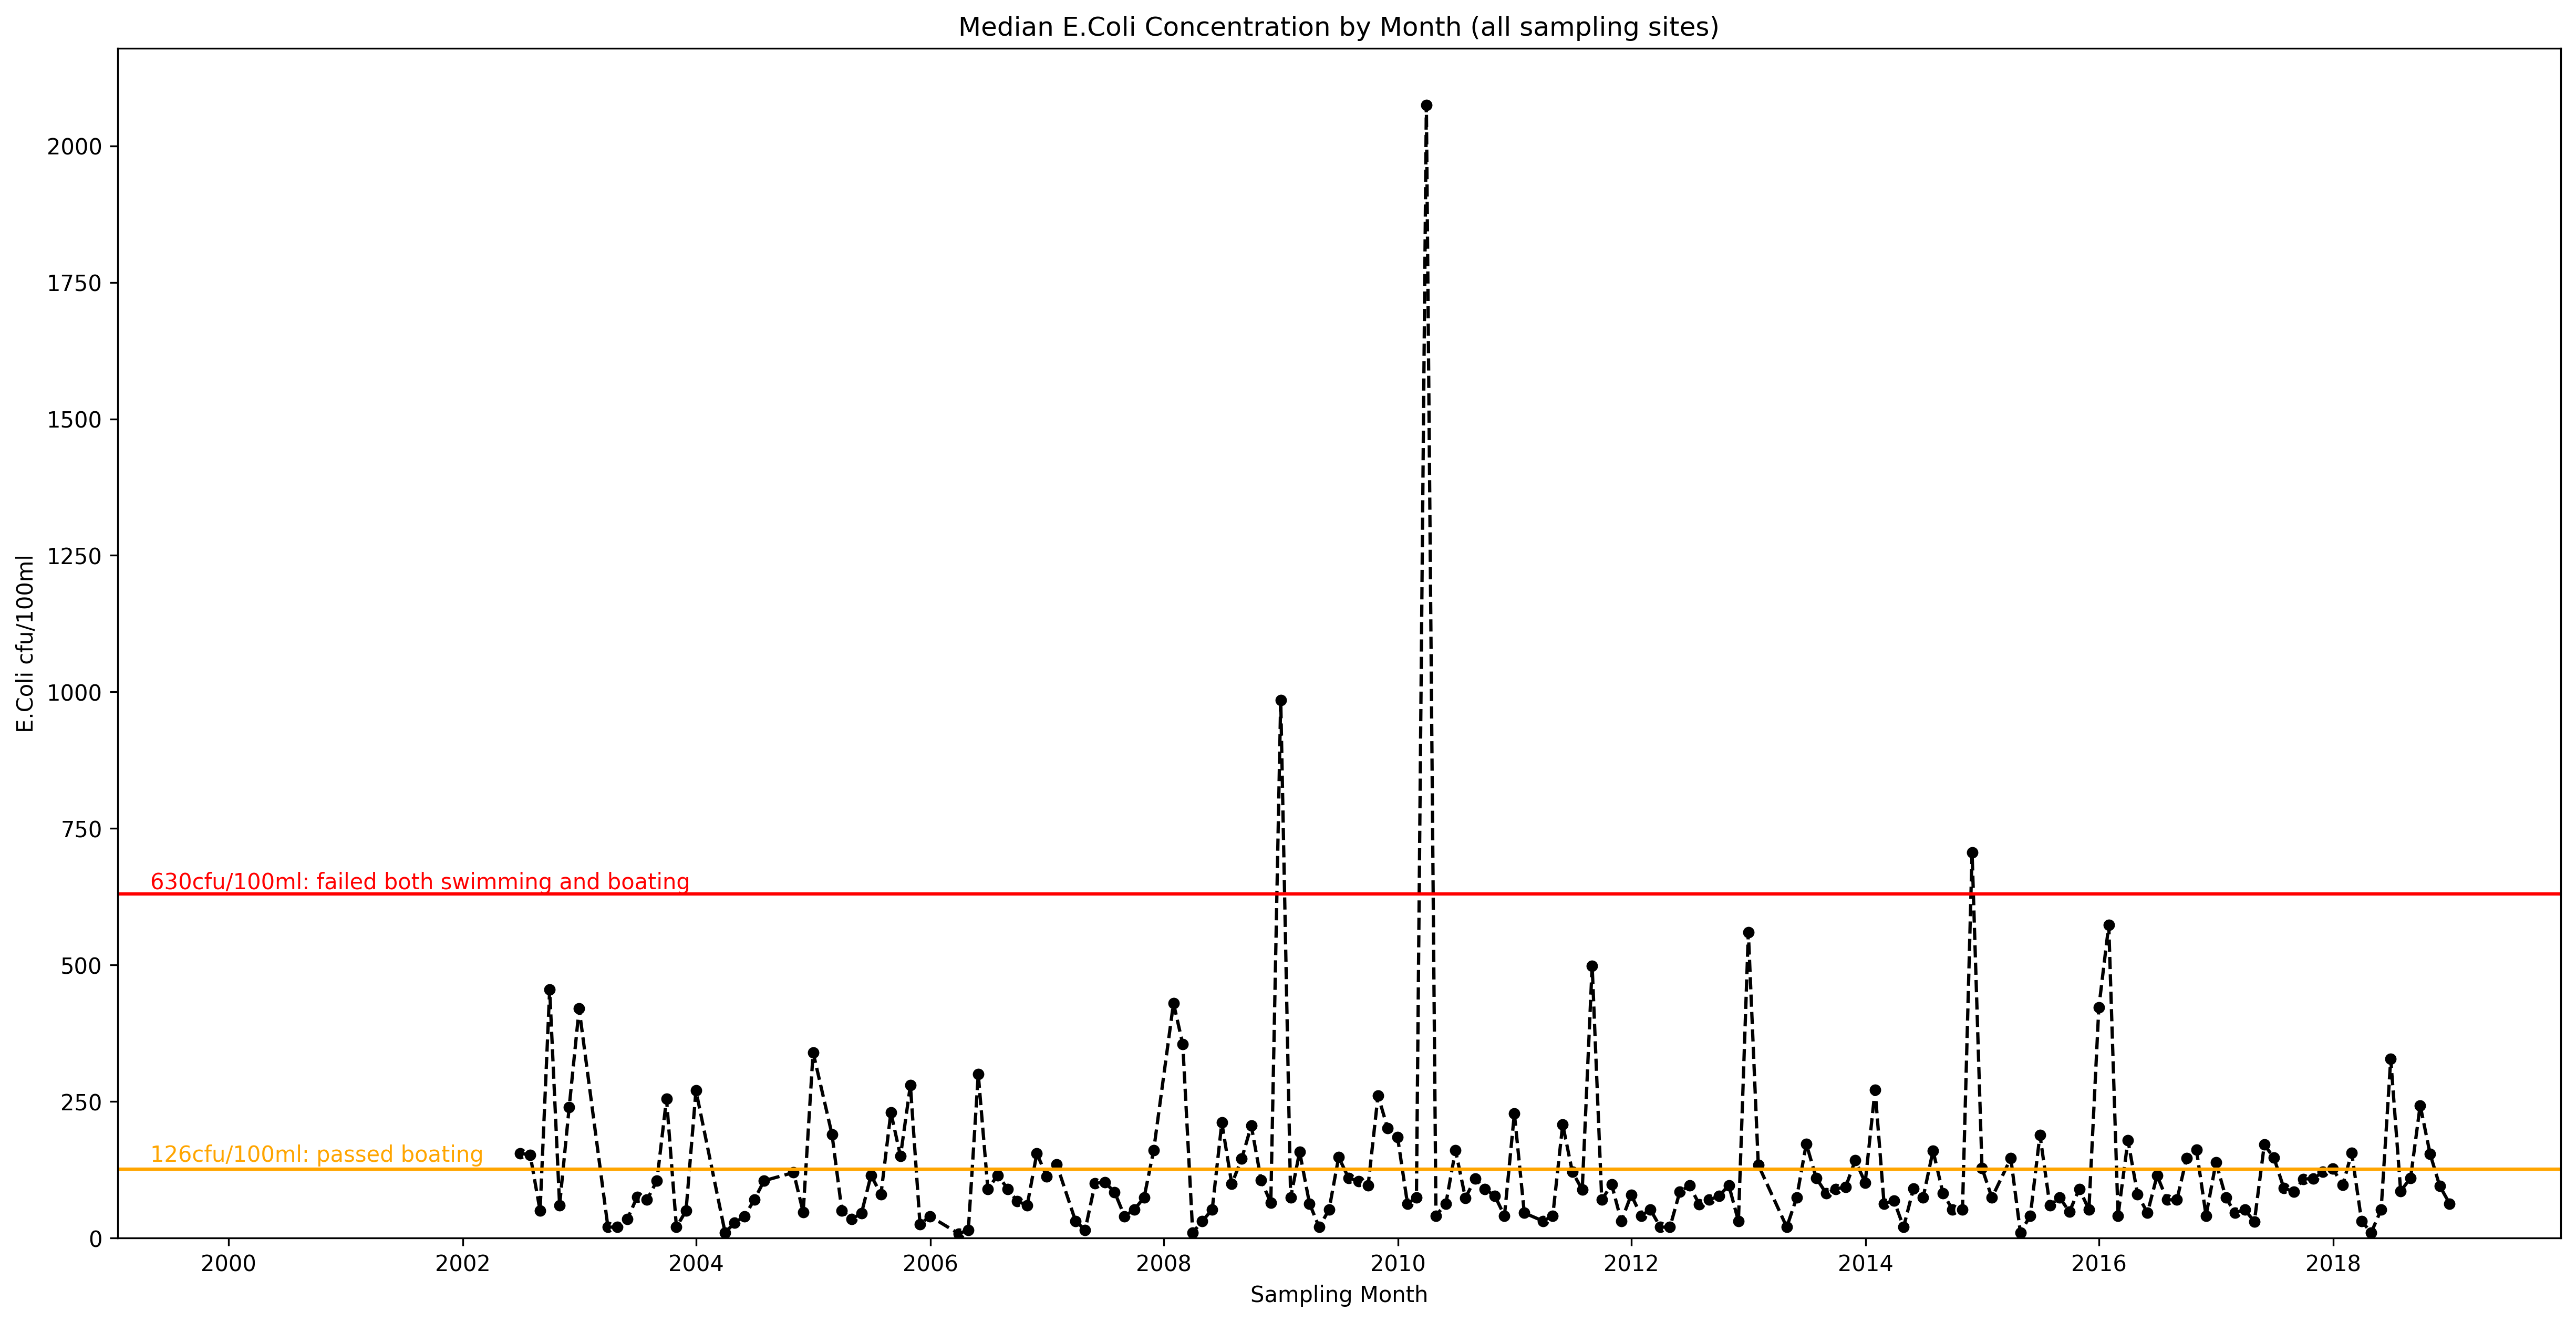

In [16]:
plt.figure(figsize=(20,10), dpi=300)

ax = sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = e_coli_month, color='black')
ax = sns.lineplot(x='Date_Collected', y='Reporting_Result', data = e_coli_month, color='black')
ax.lines[0].set_linestyle("--")

ax.set(ylim=(0, None)) # make sure to start at 0
ax.axhline(126, color="orange") # failed swimming, passed boating
ax.axhline(630, color="red") # failed boating and swimming
ax.text(dt.date(1999, 5, 1), 640, "630cfu/100ml: failed both swimming and boating", color="red")
ax.text(dt.date(1999, 5, 1), 140, "126cfu/100ml: passed boating", color="orange")

plt.title("Median E.Coli Concentration by Month (all sampling sites)")
plt.xlabel("Sampling Month")
plt.ylabel("E.Coli cfu/100ml")

plt.show()

I'm not sure if it is meaningful to pool all sampling sites together. Let's try with a single site: Watertown Dam Footbridge (because it has the most samples and I know where it is).

In [17]:
# select the necessary variables and filter for E.Coli:
dam = samples[['Date_Collected', 'Reporting_Result', 'Site_Name', 'Component_Name']]
dam = dam[(dam['Site_Name'] == "Watertown Dam Footbridge") & (dam['Component_Name'] == "Escherichia coli")]
dam.Date_Collected = pd.to_datetime(dam.Date_Collected, utc=True).dt.date
dam.Date_Collected = pd.to_datetime(dam.Date_Collected) # not sure why I have to redo this so that it remains in datetime format?
dam.set_index(dam["Date_Collected"], inplace=True) # easier to group be month later
print(dam.shape)
dam.head()

(181, 4)


,Date_Collected,Reporting_Result,Site_Name,Component_Name
Date_Collected,,,,
2002-06-18,2002-06-18,370.0,Watertown Dam Footbridge,Escherichia coli
2002-07-16,2002-07-16,1100.0,Watertown Dam Footbridge,Escherichia coli
2002-08-20,2002-08-20,260.0,Watertown Dam Footbridge,Escherichia coli
2002-09-17,2002-09-17,1600.0,Watertown Dam Footbridge,Escherichia coli
2002-10-15,2002-10-15,0.5,Watertown Dam Footbridge,Escherichia coli


Let's try to plot the raw data without grouping first:

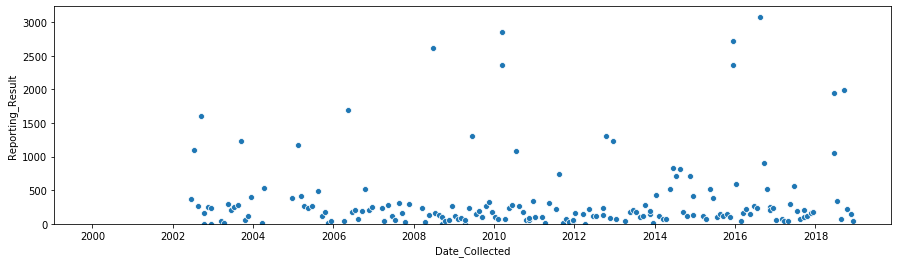

In [18]:
# let's plot again, by limiting the y axis, just to see:
plt.figure(figsize=(15,4))
ax = sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = dam)
ax.set(ylim=(0, None))
plt.show()

In [19]:
# take the median by month:
dam_month = dam.groupby(pd.Grouper(freq='M'))['Reporting_Result'].median().reset_index()

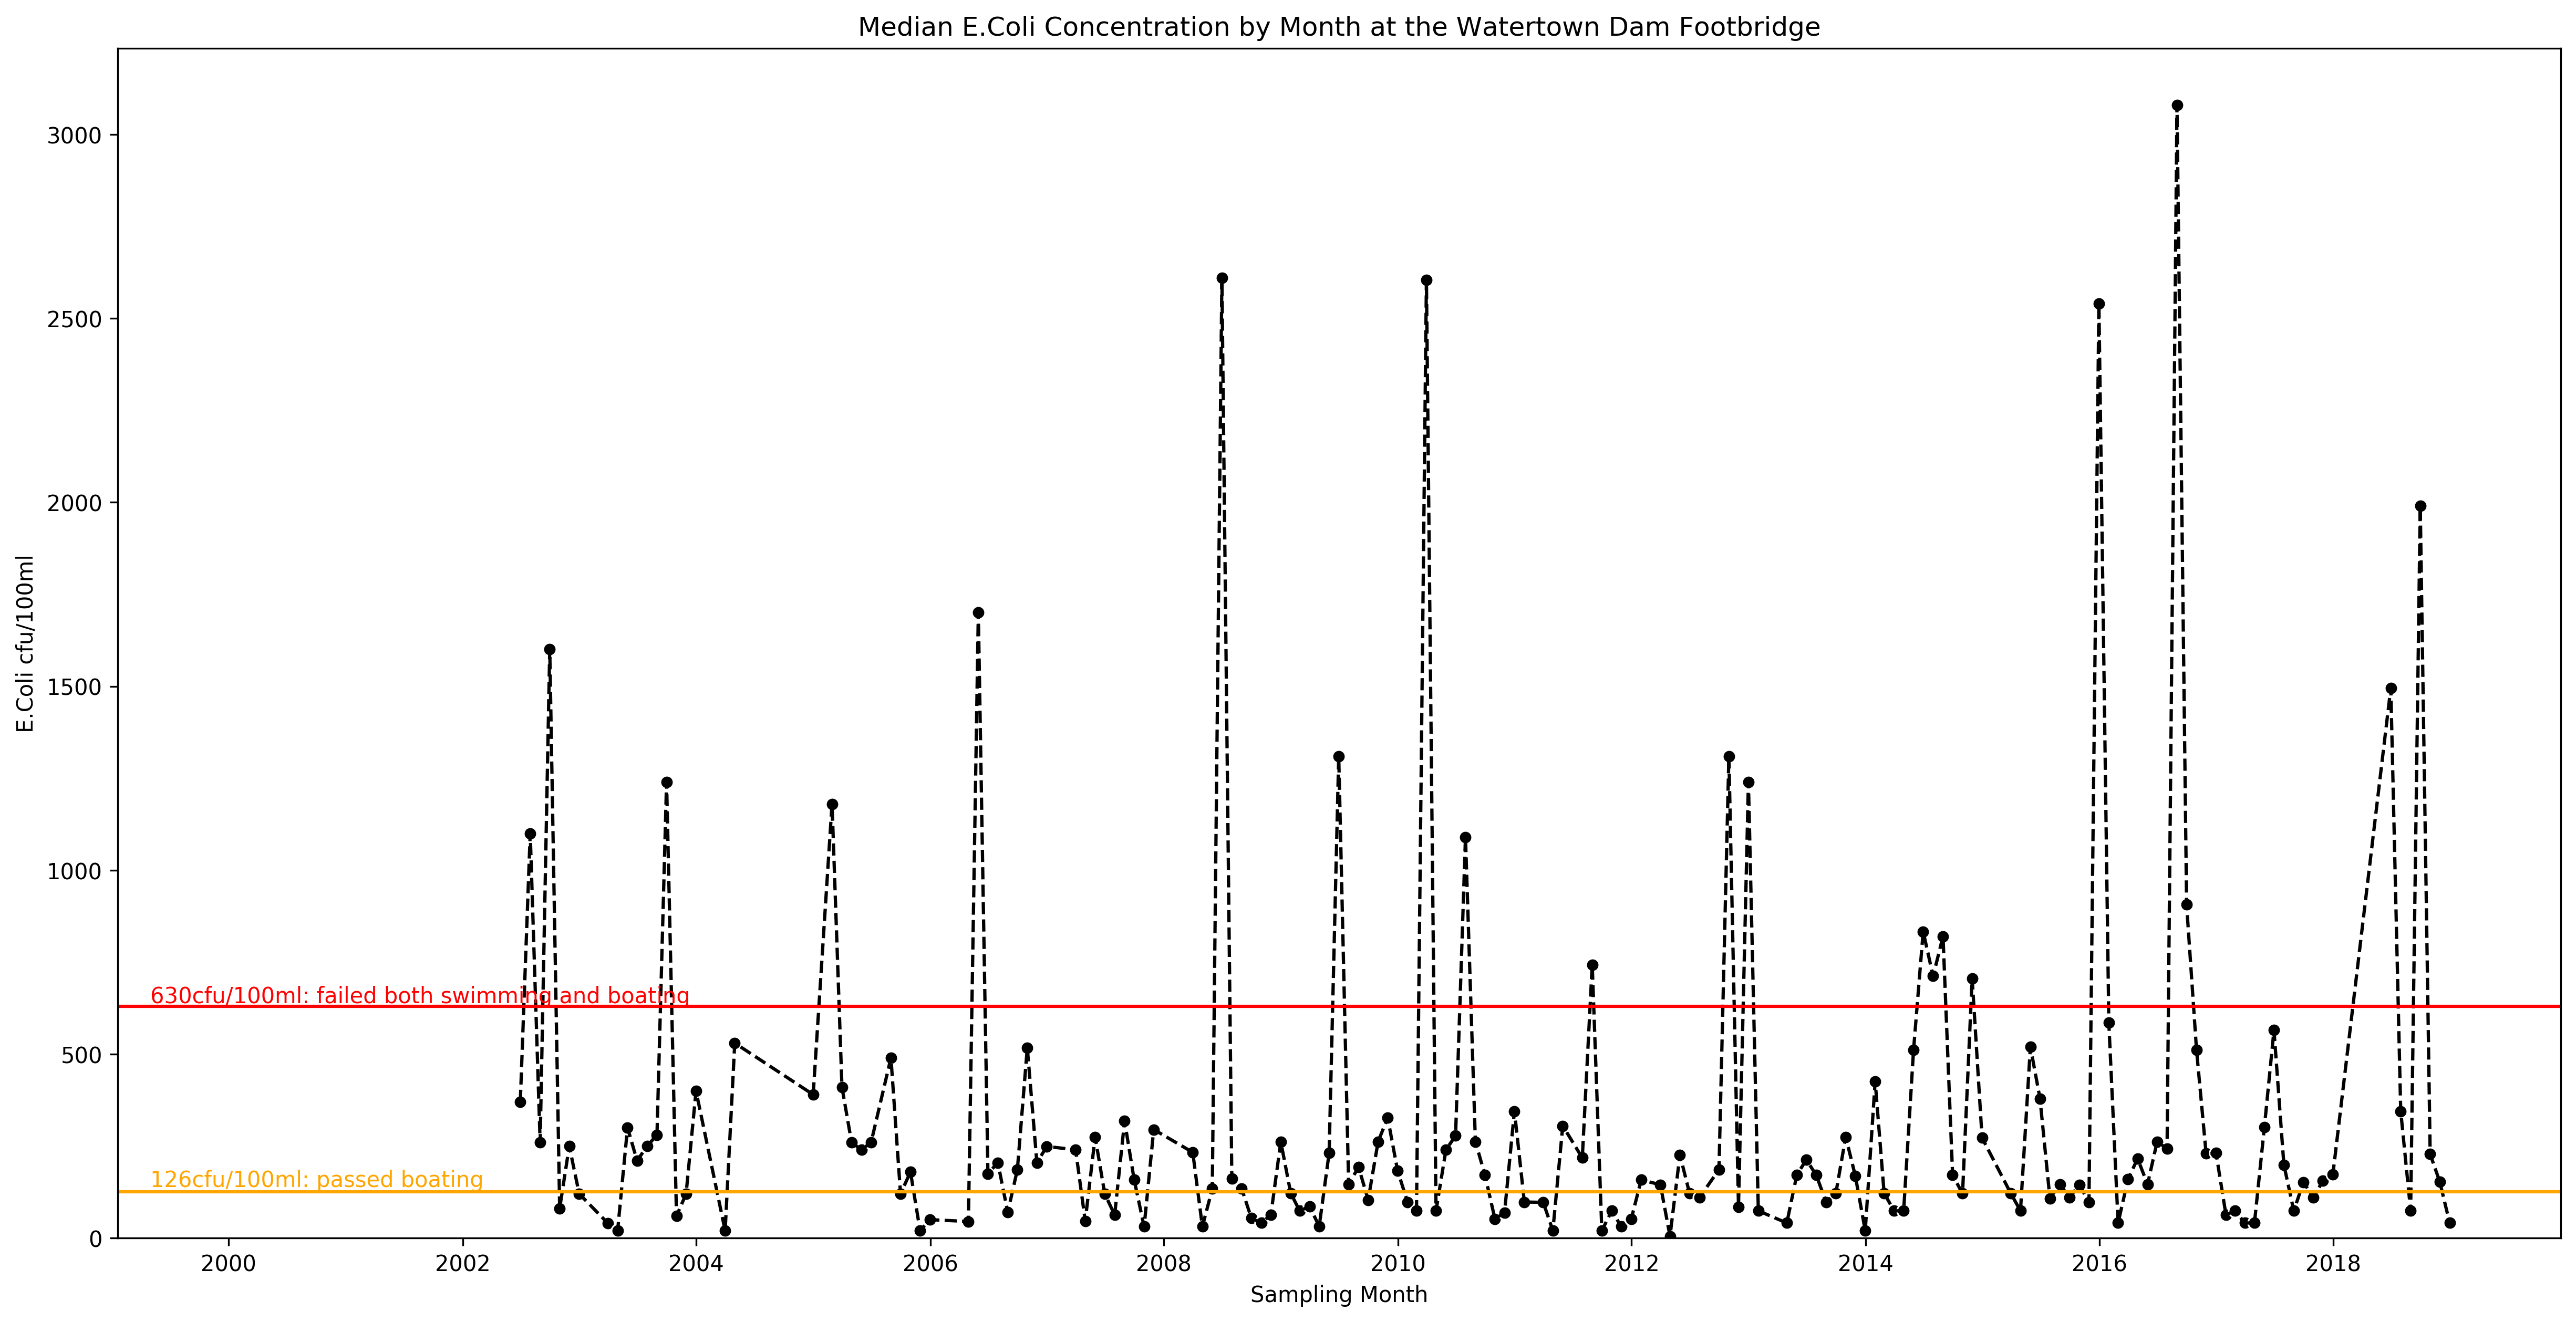

In [20]:
plt.figure(figsize=(20,10), dpi=300)

ax = sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = dam_month, color='black')
ax = sns.lineplot(x='Date_Collected', y='Reporting_Result', data = dam_month, color='black')
ax.lines[0].set_linestyle("--")

ax.set(ylim=(0, None)) # make sure to start at 0
ax.axhline(126, color="orange") # failed swimming, passed boating
ax.axhline(630, color="red") # failed boating and swimming
ax.text(dt.date(1999, 5, 1), 640, "630cfu/100ml: failed both swimming and boating", color="red")
ax.text(dt.date(1999, 5, 1), 140, "126cfu/100ml: passed boating", color="orange")

plt.title("Median E.Coli Concentration by Month at the Watertown Dam Footbridge")
plt.xlabel("Sampling Month")
plt.ylabel("E.Coli cfu/100ml")

plt.show()

Let's save the data at the Watertown Dam Footbridge so that we can use it in another plotting tool.

In [35]:
dam_month.to_csv(path_or_buf="../data/sampling_datasets/EColi_WatertownDam_Timeseries.csv")


In [43]:
# compute some basic stats to add to the visualization's description:
n_obs = dam_month.shape[0] - dam_month.isnull().sum()[1]
print("Number of months where a sample was collected: ", n_obs)

dam_month_complete = dam_month.dropna() # keep only months where data was collected for the stats.
dam_month_complete.loc[:,'Category'] = np.select(
    [
        dam_month_complete['Reporting_Result'].between(0, 126, inclusive=True), 
        dam_month_complete['Reporting_Result'].between(127, 630, inclusive=True),
        dam_month_complete['Reporting_Result'] > 630
    ], 
    [
        'Safe to swim and boat', 
        'Safe to boat, not safe to swim',
        'Not safe to swim or boat'
    ], 
    default='Unknown'
)

dam_month_complete.head()

Number of months where a sample was collected:  165


,Date_Collected,Reporting_Result,Category
0,2002-06-30,370.00,"Safe to boat, not safe to swim"
1,2002-07-31,1100.00,Not safe to swim or boat
2,2002-08-31,260.00,"Safe to boat, not safe to swim"
3,2002-09-30,1600.00,Not safe to swim or boat
4,2002-10-31,80.25,Safe to swim and boat


In [55]:
# To compute the percentages (ugly I know):
for n in dam_month_complete.Category.value_counts():
    print(100*n/dam_month_complete.shape[0])
dam_month_complete.Category.value_counts()

48.484848484848484
38.78787878787879
12.727272727272727


Safe to boat, not safe to swim    80
Safe to swim and boat             64
Not safe to swim or boat          21
Name: Category, dtype: int64